# Introduction to Synthetic Aperture Radar Using Python and MATLAB 

## by Andy Harrison - © 2022 Artech House

---

## Example 3.4.5 Polar Format Algorithm - Point Targets

---

**Import modules**

In [1]:
%matplotlib inline

import numpy as np

from scipy.constants import speed_of_light, pi

from matplotlib import pyplot as plt

from scipy.interpolate import griddata

import warnings

**Set the range to the center of the image (m)**

In [2]:
range_center = 1000

**Set the target locations (m) and RCS (m<sup>2</sup>)**

In [3]:
x_target = [10, -5, 2.5, -2.5]

y_target = [10, -5, -1, 8]

rcs = [10, 10, 7, 5]

**Set the image x and y spans (m)**

In [4]:
x_span = 30

y_span = 30

**Set the number of bins in the image**

In [5]:
nx = 1000 # Number of bins in x-direction

ny = 1000 # Number of bins in y-direction

**Set the sensor bandwidth and starting frequency (Hz)**

In [6]:
start_frequency = 5e9

bandwidth = 250e6

**Set the azimuth span of the synthetic aperture (deg)**

In [7]:
az_start = -1

az_end = 1

**Set the dynamic range for display (dB)**

In [8]:
dynamic_range = 25

**Set up the azimuth space**

In [9]:
r = np.sqrt(x_span**2 + y_span**2)

da = speed_of_light / (2.0 * r * start_frequency)

na = np.round(np.degrees(az_end - az_start) / da)

na = 2000

az = np.linspace(az_start, az_end, int(na))

**Set up the frequency space**

In [10]:
df = speed_of_light / (2.0 * r)

nf = np.floor(bandwidth / df)

frequency = np.linspace(start_frequency, start_frequency + bandwidth, int(nf))

**Calculate the signal (k space)**

In [11]:
# Initialize the signal and k-space

signal = np.zeros((int(nf), int(na)), dtype=complex)

kx = np.zeros_like(signal)

ky = np.zeros_like(signal)

kc = 2 * pi * frequency / speed_of_light


# Short hand and helps with computational load

ca = np.cos(np.radians(az))

sa = np.sin(np.radians(az))


i = 0
# Loop over all azimuth angles
for a, c, s in zip(az, ca, sa):
        
    r_los = [c, s]
    
    kx[:, i] = kc * c
    
    ky[:, i] = kc * s
    
    for xt, yt, rt in zip(x_target, y_target, rcs):
    
        r_target = np.dot(r_los, [-xt, -yt])
        
        signal[:, i] += rt * np.exp(1j * 2.0 * kc * r_target)
        
    i += 1

**Display the results**

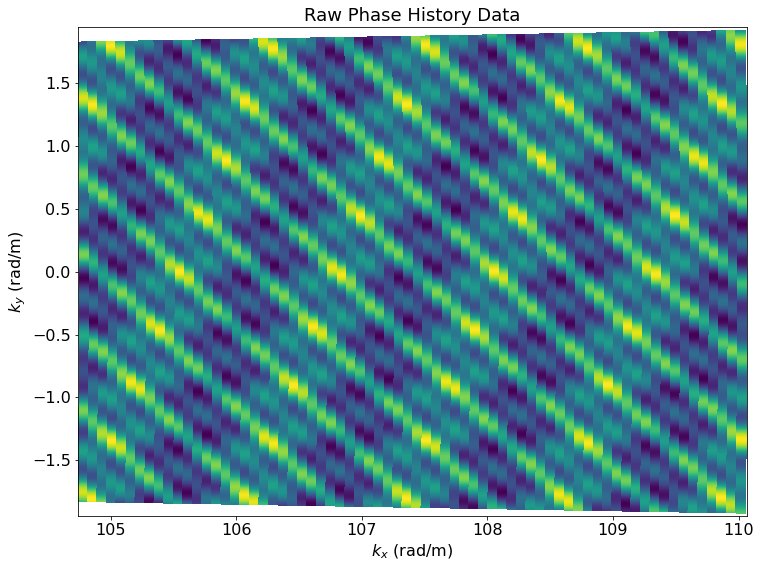

In [12]:
# Ignore warning about irregular data
warnings.filterwarnings('ignore')



# Set the figure size
plt.rcParams["figure.figsize"] = (12, 9)



# Plot the raw phase history data
plt.figure

plt.pcolor(kx, ky, signal.real)



# Set the plot title and labels

plt.title('Raw Phase History Data', size=18)

plt.xlabel('$k_x$ (rad/m)', size=16)

plt.ylabel('$k_y$ (rad/m)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Makes axes equal

plt.axis('equal')

# plt.gca().set_aspect('equal', adjustable='box')



# Show the figure

plt.show()

**Set up the wavenumber space**

In [13]:
kxmin = np.min(kx)
kxmax = np.max(kx)


kymin = np.min(ky)
kymax = np.max(ky)


kxp = np.linspace(kxmin, kxmax)
kyp = np.linspace(kymin, kymax)


kxp, kyp = np.meshgrid(kxp, kyp)

**Set up the interpolation**

In [14]:
# Perform interpolation (griddata limitations)
new_signal = griddata((kx.ravel(), ky.ravel()), signal.ravel(), (kxp, kyp), method='linear', fill_value=0)

**Display the results**

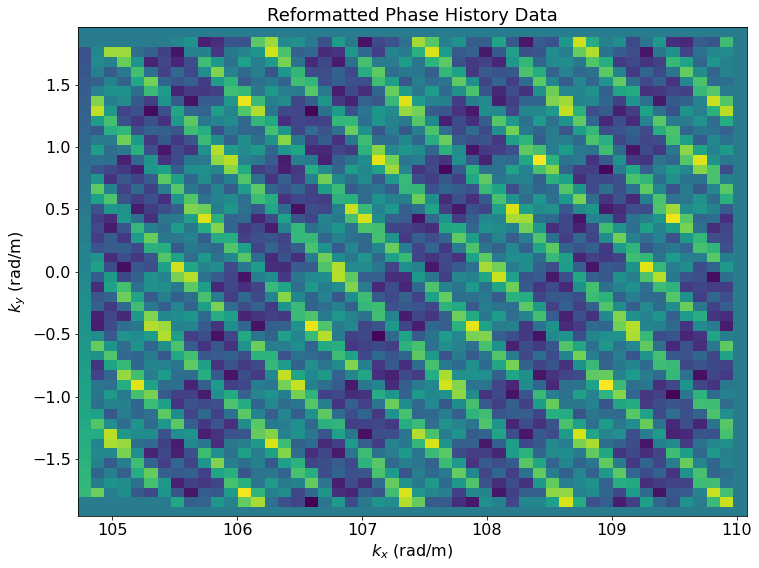

In [15]:
# Plot the reformatted phase history data

plt.figure

plt.pcolor(kxp, kyp, new_signal.real)



# Set the plot title and labels

plt.title('Reformatted Phase History Data', size=18)

plt.xlabel('$k_x$ (rad/m)', size=16)

plt.ylabel('$k_y$ (rad/m)', size=16) 



# Set the tick label size

plt.tick_params(labelsize=16)



# Make the axes equal

plt.axis('equal')

# plt.gca().set_aspect('equal', adjustable='box')



# Show the figure

plt.show()

**Calculate the frequency step size (Hz)**

In [16]:
frequency_step = speed_of_light / (2 * pi) * (kxp[0,1] - kxp[0,0])

**Calculate the maximum scene size and resolution (m)**

In [17]:
range_extent = speed_of_light / (2 * frequency_step)

**Calculate the range window for the pulses (m)**

In [18]:
range_window = np.linspace(-0.5 * range_extent, 0.5 * range_extent, int(nx))

**Calculate the frequency step size (Hz)**

In [19]:
frequency_step = speed_of_light / (2 * pi) * (kyp[1,0] - kyp[0,0])

**Calculate the maximum scene size and resolution (m)

In [20]:
cross_range_extent = speed_of_light / (2 * frequency_step)

**Calculate the cross-range window for the pulses (m)**

In [21]:
cross_range_window = np.linspace(-0.5 * cross_range_extent, 0.5 * cross_range_extent, int(ny))

**Range compress the data**

In [22]:
r_signal = np.fft.fftshift(np.fft.ifft(new_signal, int(nx), axis=1), 1)

kypp = np.linspace(np.min(ky), np.max(ky))

**Plot the range compressed data**

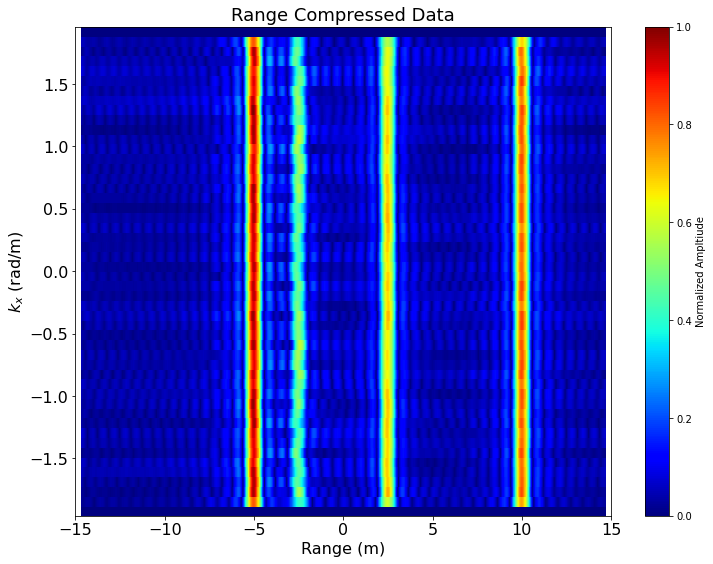

In [23]:
# Plot the range compressed data

plt.figure

plt.pcolor(range_window, kypp, np.abs(r_signal)/np.max(np.abs(r_signal)), cmap='jet')



# Set the limits for the x-axis

plt.xlim(-0.5 * x_span, 0.5 * x_span)



# Set the title and labels

plt.title('Range Compressed Data', size=18)

plt.xlabel('Range (m)', size=16)

plt.ylabel('$k_x$ (rad/m)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Turn on the colorbar and set the label

cbar = plt.colorbar()

cbar.set_label('Normalized Ampltiude')



# Show the figure

plt.show()

**Compress the signal in azimuth**

In [24]:
ra_signal = np.fft.fftshift(np.fft.ifft(r_signal, int(ny), axis=0), 0)

**Display the results**

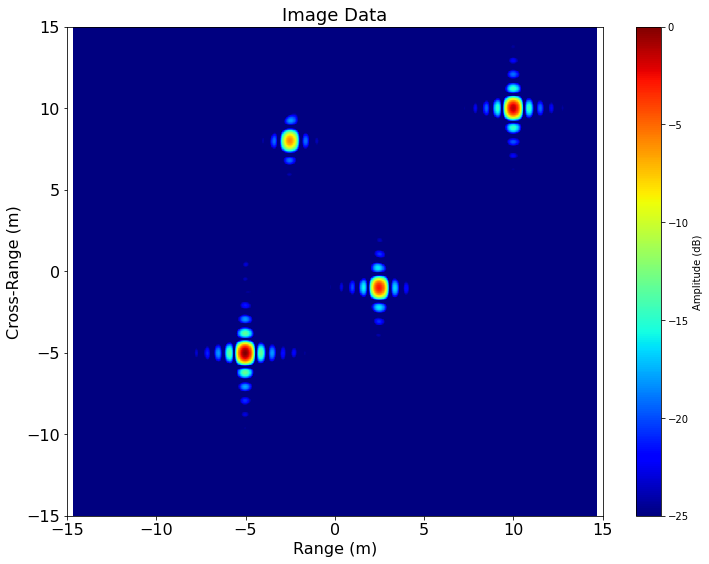

In [25]:
# Plot the focused image
plt.figure 

plt.pcolor(range_window, cross_range_window, 20 * np.log10(np.abs(ra_signal)/np.max(np.abs(ra_signal))), cmap='jet', vmin=-abs(dynamic_range), vmax=0)

plt.xlim([-0.5 * x_span, 0.5 * x_span])

plt.ylim([-0.5 * y_span, 0.5 * y_span])



# Set the title and labels

plt.title('Image Data', size=18)

plt.xlabel('Range (m)', size=16)

plt.ylabel('Cross-Range (m)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Make the axes equal

# plt.axis('equal')

# plt.gca().set_aspect('equal', adjustable='box')



# Turn on the colorbar and set the label

cbar = plt.colorbar()

cbar.set_label('Amplitude (dB)')



# Show the figure

plt.show()